In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

2023-07-31 15:27:39.986343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load and prepare data

In [2]:
return_sequences = False
n = 10000
time_span = 5
c = 100
time_step = 0.1
integration_time_step = 0.01
std = 0

In [77]:
# Load the observations
name = f"{n}_{time_span}_{c}_{str(time_step).replace('.', '')}_{str(integration_time_step).replace('.', '')}_{std}"
observations = np.load(f"data_no_std/test_observations_{name}.npy")
predictions = np.load(f"data_no_std/test_predictions_{name}.npy")
print(f"observation array shape = {observations.shape}")


observation array shape = (10000, 51, 3)


In [81]:
# Scale the data
maximum = max( np.max(np.abs(observations)), np.max(np.abs(observations)))
observations_scaled = observations/maximum
predictions_scaled = predictions/maximum

48.52176290761893


In [95]:
# Split into training and test data

frac = 0.9
num_samples = observations_scaled.shape[0]
cut_off = int(frac*num_samples)

train_x = observations_scaled[:cut_off,:-1, :]
test_x = observations_scaled[cut_off:,:-1, :]
if return_sequences:
    train_answer = observations_scaled[:cut_off, 1:, :]
    test_answer = observations_scaled[cut_off:, 1:, :]
    train_prediction = predictions_scaled[:cut_off, 1:, :]
    test_prediction = predictions_scaled[cut_off:, 1:, :]
else:
    train_answer = observations_scaled[:cut_off, -1, :]
    test_answer = observations_scaled[cut_off:, -1, :]
    train_prediction = predictions_scaled[:cut_off, -1, :]
    test_prediction = predictions_scaled[cut_off:, -1, :]
print(f"shape of training data = {train_x.shape}")
print(f"shape of training predictions = {train_prediction.shape}")
print(f"shape of training answers = {train_answer.shape}")



shape of training data = (9000, 50, 3)
shape of training predictions = (9000, 3)
shape of training answers = (9000, 3)


In [ ]:
# Split into training and test data

frac = 0.9
num_samples = observations_scaled.shape[0]
train_x = observations_scaled[:int(frac*num_samples),:-1, :]
test_x = observations_scaled[int(frac*num_samples):,:-1, :]
if return_sequences:
    train_answer = observations_scaled[:int(frac*num_samples), 1:, :]
    test_answer = observations_scaled[int(frac*num_samples):, 1:, :]
else:
    train_answer = observations_scaled[:int(frac*num_samples), -1, :]
    test_answer = observations_scaled[int(frac*num_samples):, -1, :]
print(f"shape of training data = {train_x.shape}")
print(f"shape of training answers = {train_answer.shape}")

Create the architecture

In [83]:
# Create the architecture
# model = keras.Sequential()

observation_input = layers.Input(shape=(None,3))
observation_LSTM = layers.LSTM(64, input_shape=(None, 3), return_sequences=return_sequences)(observation_input)

prediction_input = layers.Input(shape=(3))
prediction_activation = layers.Activation('linear')(prediction_input)

merge_layers = layers.Concatenate(axis=-1)([observation_LSTM, prediction_activation])
merge_dense = layers.Dense(16)(merge_layers)
output = layers.Dense(3)(merge_dense)

model = keras.Model(inputs=[observation_input, prediction_input], outputs = output)


model.summary()

model.compile(loss='mse', optimizer='adam')

# https://stackoverflow.com/questions/60679680/how-to-combine-two-lstm-layers-with-different-input-sizes-in-keras

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, None, 3)]            0         []                            
                                                                                                  
 input_44 (InputLayer)       [(None, 3)]                  0         []                            
                                                                                                  
 lstm_48 (LSTM)              (None, 64)                   17408     ['input_43[0][0]']            
                                                                                                  
 activation_47 (Activation)  (None, 3)                    0         ['input_44[0][0]']            
                                                                                            

Train the model

In [99]:
# Train the model
history = model.fit(x=[train_x, train_prediction] , y=train_answer, epochs=5, validation_data=(test_x, test_answer), batch_size=32, verbose=2, shuffle=True)

Epoch 1/5


ValueError: in user code:

    File "/Users/ariannacox/PycharmProjects/ChaosML/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "/Users/ariannacox/PycharmProjects/ChaosML/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ariannacox/PycharmProjects/ChaosML/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "/Users/ariannacox/PycharmProjects/ChaosML/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "/Users/ariannacox/PycharmProjects/ChaosML/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/ariannacox/PycharmProjects/ChaosML/venv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 50, 3) dtype=float32>]


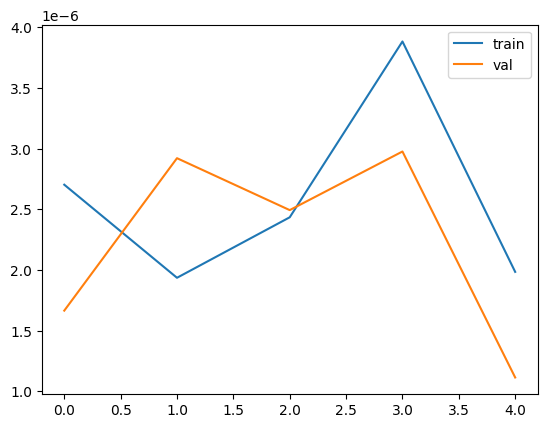

In [23]:
# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [24]:
ML_predictions = model.predict([test_x, test_prediction])
print(ML_predictions.shape)

32/32 [==============================] - 0s 12ms/step
(1000, 3)


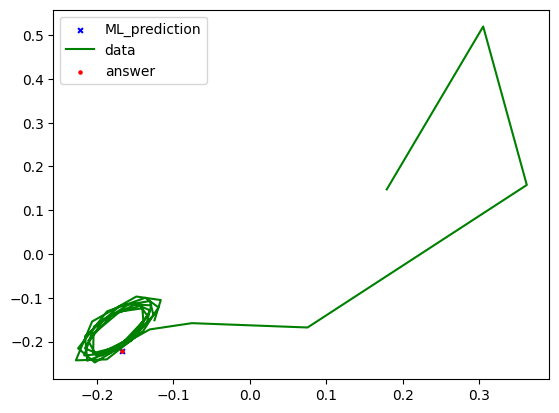

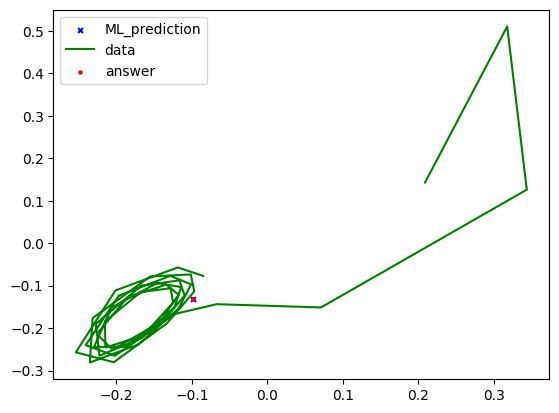

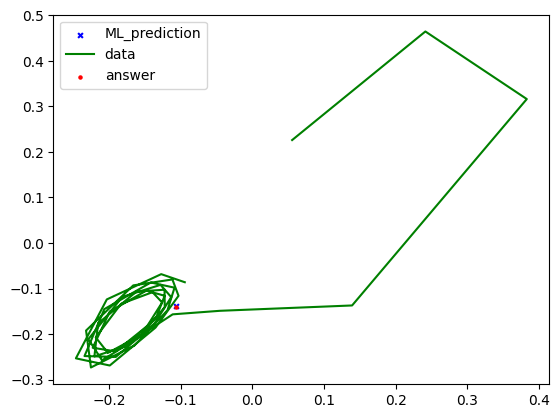

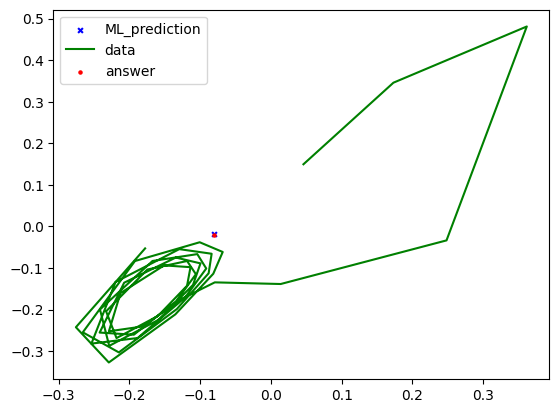

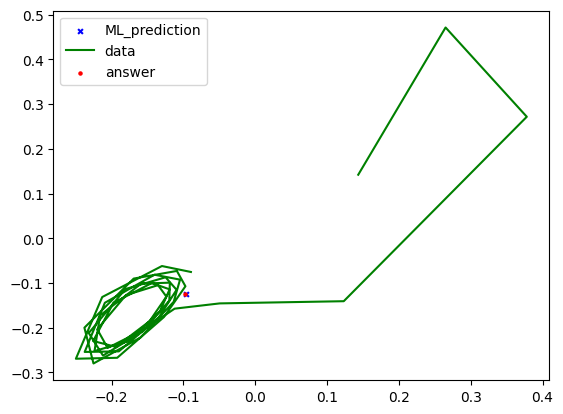

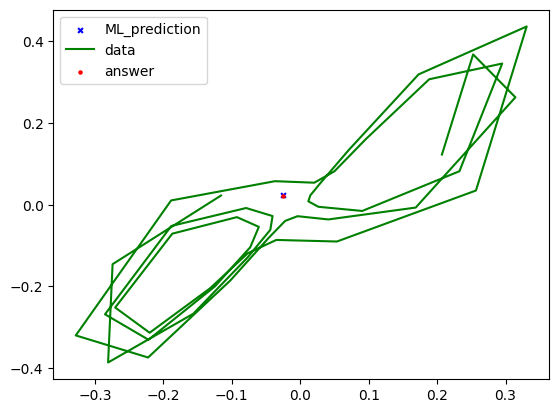

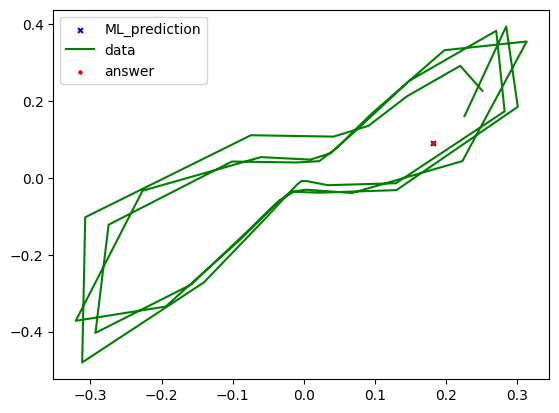

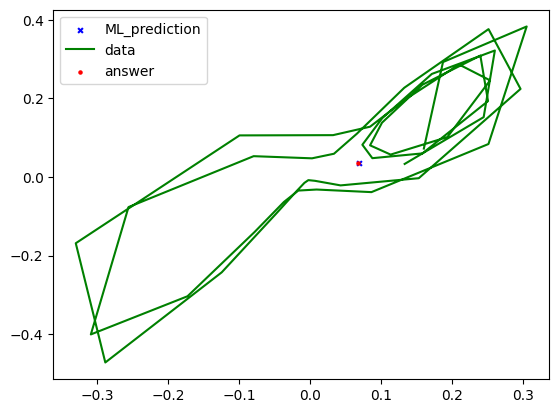

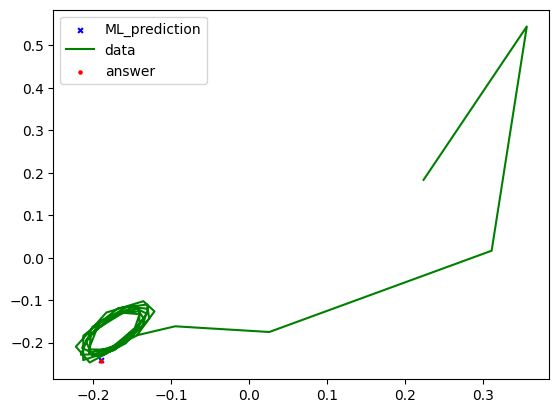

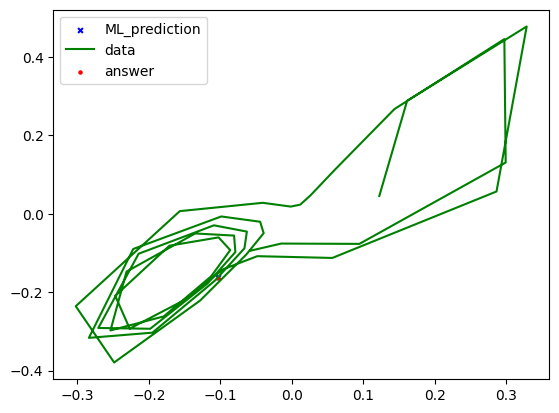

In [25]:
for i in range(10):
    plt.scatter(ML_predictions[i,0], ML_predictions[i,1], label = 'ML_prediction', s=12, marker ='x', color = 'b')
    plt.plot(test_x[i,:,0], test_x[i,:,1], label = 'data', color = 'g')
    plt.scatter(test_answer[i,0], test_answer[i,1], label = 'answer', s=5, color = 'r')
    plt.scatter(test_prediction[i,0], test_prediction[i,1], label = 'answer', s=10, color = 'y', marker ='o')
    plt.legend()
    plt.show()

Save the model

In [26]:
model.save(f'saved_models/model_MLonly_{name}.keras')